# Developing an ideal rule with Prolog

The aim  of this notebook is to hand-write a Prolog rule to distinguish between good and bad examples. Hopefully this will inform our further work in Progol. Once we have this, we can try to tweak our Progol settings and rule structure to allow it to generate a similar rule.

In [54]:
import pandas as pd
import tempfile
import subprocess
import graph_visualisation as gv

In [55]:
prolog = pd.read_csv("../data/ilp_prolog_data.csv.gz")
prolog = prolog.drop("Unnamed: 0", axis=1)
prolog.head()

,testcase_ID,flaw,bug,code_length,tree,source_map
0,-232086,CWE-122,True,1625,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232086_id_1_f_l_c_, ""p..."
1,-232012,CWE-122,True,1619,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_232012_id_0_f_l_c_, ""p..."
2,-62917,CWE-121,True,1622,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62917_id_0_f_l_c_, ""p1..."
3,-62916,CWE-121,True,1649,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62916_id_1_f_l_c_, ""p1..."
4,-62915,CWE-121,True,1638,% START: Generated Prolog\n% NODE PROPERTIES \...,"% CODE\nsource_code(bad_62915_id_0_f_l_c_, ""p1..."


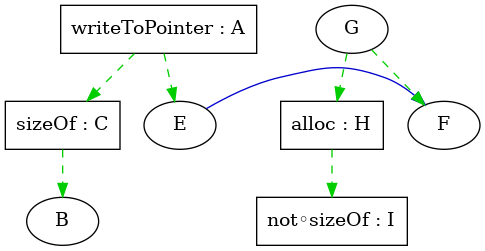

In [56]:
gv.jupyter_display_graph(gv.prolog_rule_to_dot("""
bug(A) :- writeToPointer(A), ancestor(A,C), 
	ancestor(A,E), ref(E,F), sizeOf(C), ancestor(C,B), 
	ancestor(G,F), ancestor(G,H), alloc(H), ancestor(H,I), not(sizeOf(I)).
"""))

In [57]:
positive_example = prolog[prolog['testcase_ID'] == -232086].tree.iloc[0]
negative_example = prolog[prolog['testcase_ID'] == +232086].tree.iloc[0]

In [58]:
prolog_file = """
:- discontiguous sizeOf/1. 
:- discontiguous writeToPointer/1.
:- discontiguous assignment/1.
:- discontiguous alloc/1.
:- discontiguous assignment/1.
:- discontiguous pointer/1.
:- discontiguous pointer/1.
:- discontiguous sizeOfInt/1.
:- discontiguous array10/1.
:- discontiguous sizeOfInt/1.
:- discontiguous array10/1.
:- discontiguous voidPointer/1.
:- discontiguous pointer/1.
:- discontiguous voidPointer/1.
:- discontiguous sizeOf/1. 
:- discontiguous writeToPointer/1.
:- discontiguous assignment/1.
:- discontiguous compMemberAccess/1.
:- discontiguous alloc/1.
:- discontiguous compMemberAccess/1.
:- discontiguous sizeOf/1.
:- discontiguous writeToPointer/1.
:- discontiguous assignment/1.
:- discontiguous sizeOf/1.
:- discontiguous alloc/1.
:- discontiguous assignment/1.
:- discontiguous pointer/1.
:- discontiguous voidPointer/1.
:- discontiguous pointer/1.
:- discontiguous voidPointer/1.
:- discontiguous pointer/1.
:- discontiguous sizeOfInt/1.
:- discontiguous array10/1.
:- discontiguous pointer/1.
:- discontiguous sizeOfInt/1.
:- discontiguous array10/1.
:- discontiguous sizeOfInt/1.
:- discontiguous array10/1.
:- discontiguous voidPointer/1.
:- discontiguous pointer/1.
:- discontiguous voidPointer/1.
:- discontiguous ast/2.
:- discontiguous cfg/2.
:- discontiguous ref/2.

{}

writeToPointer(A) :- ast(A,B), assignment(A), compMemberAccess(B). 

ancestor(A,C) :- ast(A,B), ancestor(B,C).
ancestor(A,C) :- ast(A,B), ast(B,C).

runs_before(A,C) :- cfg(A,B), runs_before(B,C).
runs_before(A,C) :- cfg(A,B), cfg(B,C).

bug(A) :- writeToPointer(A), ancestor(A,C), ancestor(A,E), ref(E,F), sizeOf(C), 
                ancestor(C,B), ancestor(G,F), ancestor(G,H), alloc(H), ancestor(H,I), not(sizeOf(I)).
""".format(positive_example)

Then we `docker exec` into this container, and run `cd /tmp && swipl` with the following commands:
```
$ [prolog_test].
$ bug(A).
```

And we find that no bugs match it! We need to find one which does. To help us, we draw the tree representing the positive (buggy) example:

In [59]:
ilp_data = pd.read_csv("../data/ilp_dataset.csv.gz")
ilp_data = ilp_data.drop("Unnamed: 0", axis=1)
ilp_data.head()

,testcase_ID,filename,code,flaw,flaw_loc,bug,code_length
0,62804,000/062/804/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,1722
1,62821,000/062/821/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,35,False,1808
2,62852,000/062/852/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,30,False,1674
3,62853,000/062/853/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2396
4,62854,000/062/854/CWE121_Stack_Based_Buffer_Overflow...,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,CWE-121,33,False,2414


In [60]:
def generate_dot(testcase):
    tmp_dir = tempfile.TemporaryDirectory()

    for file in testcase.itertuples():
        short_filename = file.filename.split("/")[-1]
        with open(tmp_dir.name + "/" + short_filename, 'w') as f:
            f.write(file.code)

    subprocess.check_call(["/joern/joern-parse", "--out", tmp_dir.name + "/cpg.bin.zip", tmp_dir.name])

    dot = subprocess.check_output(
        "cd /joern && /joern/joern-query --cpg "+tmp_dir.name + "/cpg.bin.zip -f /project/code/joern_cfg_to_dot.scala",
        shell=True,
        universal_newlines=True,
    )
    
    tmp_dir.cleanup()
    
    return dot

In [61]:
dot_source = generate_dot(ilp_data[ilp_data['testcase_ID'] == -232086])

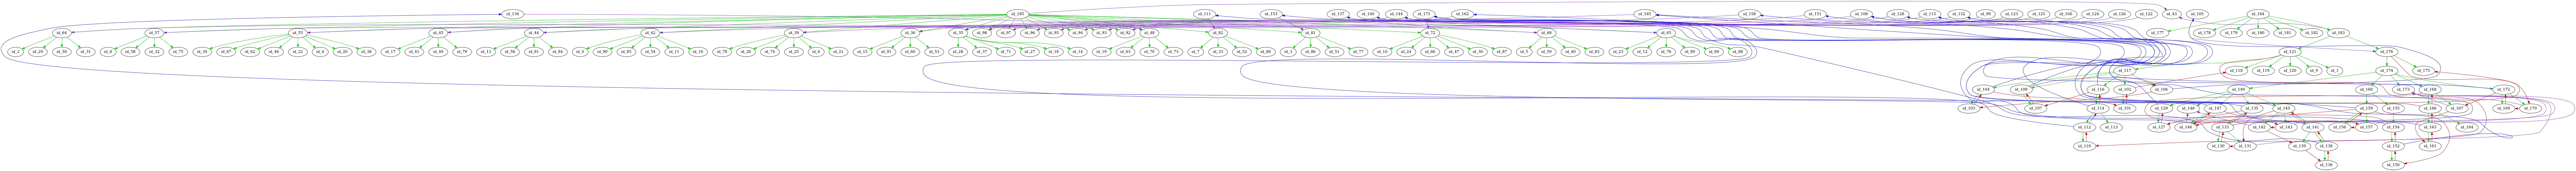

In [62]:
gv.jupyter_display_graph(dot_source)

In [63]:
print(dot_source)

digraph g {
# AST
{
  edge[color=green3,constraint=true]
  id_102 -> id_101 
   id_117 -> id_102 
   id_104 -> id_103 
   id_117 -> id_104 
   id_117 -> id_106 
   id_109 -> id_107 
   id_117 -> id_109 
   id_112 -> id_110 
   id_114 -> id_112 
   id_114 -> id_113 
   id_116 -> id_114 
   id_117 -> id_116 
   id_121 -> id_117 
   id_121 -> id_118 
   id_121 -> id_119 
   id_121 -> id_120 
   id_183 -> id_121 
   id_185 -> id_82 
   id_185 -> id_81 
   id_185 -> id_72 
   id_185 -> id_68 
   id_185 -> id_65 
   id_185 -> id_64 
   id_185 -> id_57 
   id_185 -> id_55 
   id_185 -> id_48 
   id_185 -> id_45 
   id_185 -> id_44 
   id_185 -> id_42 
   id_185 -> id_39 
   id_185 -> id_36 
   id_185 -> id_35 
   id_185 -> id_98 
   id_185 -> id_97 
   id_185 -> id_96 
   id_185 -> id_95 
   id_185 -> id_94 
   id_185 -> id_93 
   id_185 -> id_92 
   id_121 -> id_9 
   id_121 -> id_1 
   id_65 -> id_23 
   id_72 -> id_10 
   id_42 -> id_11 
   id_44 -> id_13 
   id_68 -> id_5 
   id_82 -> id_

We then copy and paste this into the viewer at http://viz-js.com/ and try to figure out a rule...

In [64]:
# TBC...